#### Standard imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.style.use("ggplot")

# Modeling imports
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor,TheilSenRegressor, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# define graph palette
palette = ["#ffb4bfff","#fbfbaaff","#ffc7f0ff","#d2ffbeff","#ffd380ff","#b9cdffff"]

#### Load cleaned data

In [5]:
# load clean data
train_df = pd.read_csv('../data/train_cleaned.csv')
store_df = pd.read_csv('../data/store_711_en.csv')
bkk_zone_df = pd.read_csv('../data/bkk_zone.csv')
store_zone = pd.merge(left=store_df, right=bkk_zone_df)

#### Defined helper function

In [7]:
def evaluate_model(model, X, X_train, X_test, y, y_train, y_test, y_pred, x_title='Actual', y_title='Predicted', title=''):
    score = cross_val_score(model, X, y, cv=5).mean()
    # show model performance
    name = str(model)
    print(f"Cross Validation Score of {name}: {score:.6f}")
    print(f"R^2 of {name}: {r2_score(y_test, y_pred):.6f}")
    print(f"RMSE of {name}: {root_mean_squared_error(y_test, y_pred):.4f}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(5, 5))
    sns.regplot(y=y_test, x=y_pred, scatter_kws={'color': 'blue'})
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values for {name}')

    # Plot residual values
    plt.figure(figsize=(5, 5))
    sns.residplot(y=y_test, x=y_pred, scatter_kws={'color': 'blue'})
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Residual plot for {name}')

### Model 1 [Project Goal]. Predict Housing Price

#### Get dummy columns

In [10]:
# Get dummy columns
train_dummy_df = pd.get_dummies(columns=['property_type', 'province', 'district'], \
                                data=train_df, drop_first=True)

In [11]:
train_dummy_df.sort_index(inplace=True)

#### Train-Test split data

Select features use for training and split data for training and test with ratio 80/20

In [14]:
features = [c for c in train_dummy_df.columns if re.search(r'bedrooms|baths|floor_area|floor_level|property|province_|district_', c)]
X = train_dummy_df[features]
y = train_dummy_df['price']

In [15]:
# split data for training and test with ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### Training models & compare result

In [17]:
# scale X values
sc = RobustScaler()
# Scale the training data
X_train_sc = sc.fit_transform(X_train)

# Transform the predict data
X_test_sc = sc.transform(X_test)

Cross Validation Score of LinearRegression(): 0.625255
R^2 of LinearRegression(): 0.630306
RMSE of LinearRegression(): 1332687.5928


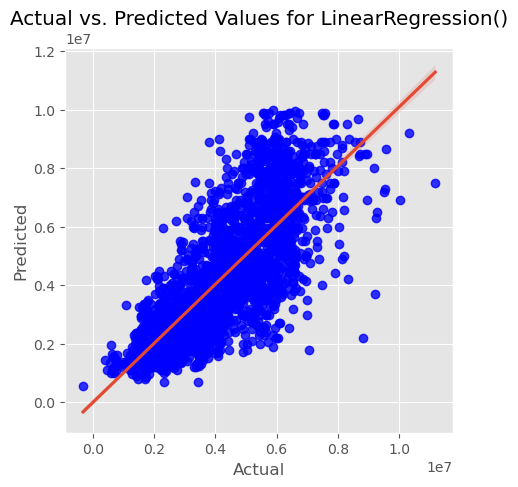

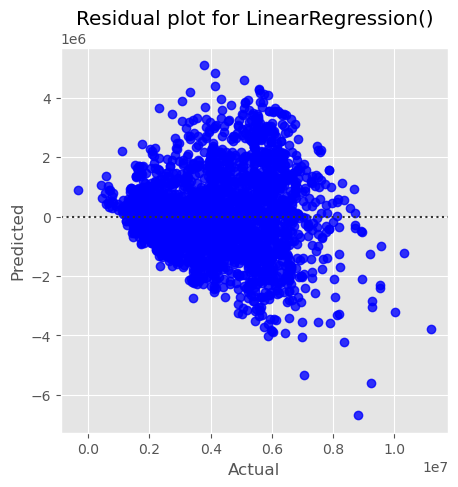

In [18]:
# use linear regression model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)

# show model performance
evaluate_model(lr, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Lasso(alpha=0.01, tol=0.1): 0.625255
R^2 of Lasso(alpha=0.01, tol=0.1): 0.630306
RMSE of Lasso(alpha=0.01, tol=0.1): 1332688.0136


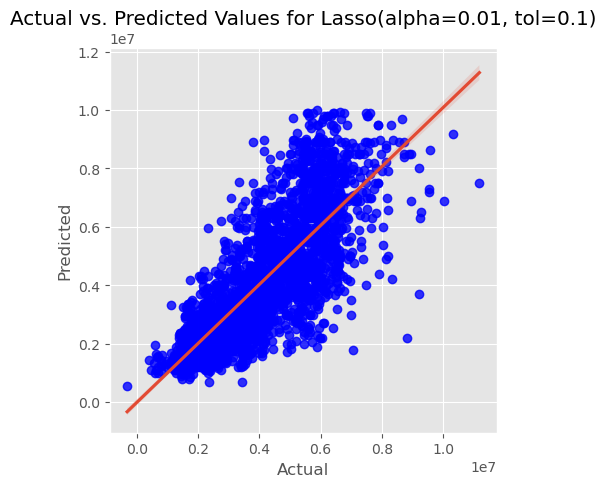

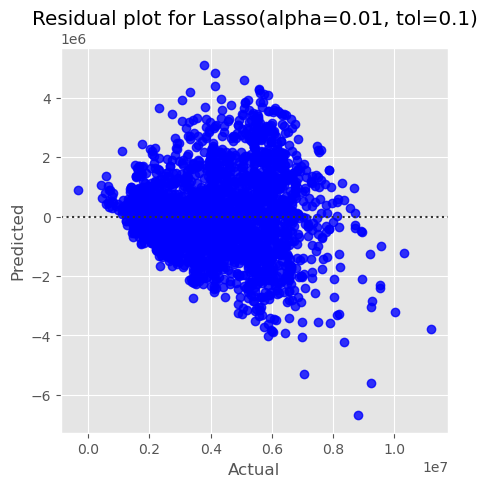

In [19]:
# use lasso model
lasso = Lasso(alpha=0.01, max_iter=1000, tol=0.1)
lasso.fit(X_train_sc, y_train)
y_pred = lasso.predict(X_test_sc)

evaluate_model(lasso, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Ridge(): 0.625279
R^2 of Ridge(): 0.630262
RMSE of Ridge(): 1332766.6599


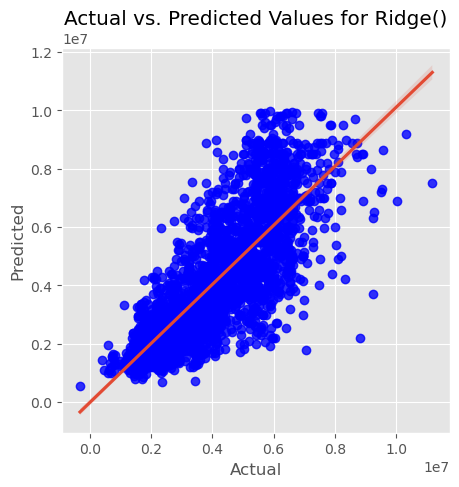

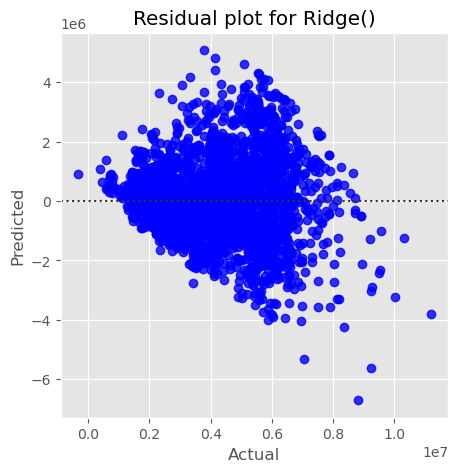

In [20]:
# use Ridge model
ridge = Ridge()
ridge.fit(X_train_sc, y_train)
y_pred = ridge.predict(X_test_sc)

evaluate_model(ridge, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

##### Conclusion

- Linear Regression achieved the highest accuracy compared to Lasso and Ridge, as measured by highest cross-validation R^2 and lowest RMSE.

### Model 2 [Optional]. Improve predict price for Condo in Bangkok with number of nearby 7-11 store

##### Feature Engineering

In [25]:
# filter only property type Condo in Bangkok
train_store_df = train_df[(train_df['province'] == 'Bangkok') & (train_df['property_type'] == 'Condo')].copy()

##### Find nearby 7-11 within 1 km. grid from Condo in Bangkok

In [27]:
# distance for latitude and longitude of 0.01 degress ~ 1 km.

# round latitude and longitude for training data
train_store_df['round_longitude'] = train_store_df['longitude'].map(lambda x: round(x, 2))
train_store_df['round_latitude'] = train_store_df['latitude'].map(lambda x: round(x, 2))

# round latitude and longitude for 7-11 store data
store_df.loc[:,'round_longitude'] = store_df['longitude'].map(lambda x: round(x, 2))
store_df.loc[:,'round_latitude'] = store_df['latitude'].map(lambda x: round(x, 2))

# do grid search 7-11 store within range ~1 km.
for lat in np.arange(round(train_store_df['latitude'].min(), 2), round(train_store_df['latitude'].max(),2), 0.01):
    for lng in np.arange(round(train_store_df['longitude'].min(), 2), round(train_store_df['longitude'].max(),2), 0.01):
        appx_lat = round(lat,2)
        appx_lng = round(lng,2)
        house_df = train_store_df[(train_store_df['round_longitude'] == appx_lng) & (train_store_df['round_latitude'] == appx_lat)]
        found_store_df = store_df[(store_df['round_longitude'] == appx_lng) & (store_df['round_latitude'] == appx_lat)]
        if len(house_df['id']) and len(found_store_df):
            train_store_df.loc[(train_store_df['round_longitude'] == appx_lng) & (train_store_df['round_latitude'] == appx_lat), 'nearby_711_store_num'] \
                 = len(found_store_df)

# Mapped district to Bangkok zone name
train_store_zone_df = pd.merge(left=train_store_df, right=bkk_zone_df.rename({'district_en': 'district'}, axis=1))

In [28]:
# create dummy for property_type, province and district
train_store_df = pd.get_dummies(columns=['property_type', 'district'], data=train_store_df, drop_first=True)

#### Train-Test split data

In [30]:
train_store_df['nearby_711_store_num'] = train_store_df['nearby_711_store_num'].fillna(0)
features = [c for c in train_store_df.columns if re.search(r'nearby_711_store_num|total_units|bedrooms|baths|floor_area|floor_level|property|district_', c)]
X = train_store_df[features]
y = train_store_df['price']

In [31]:
# split data for training and test with ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### Training models & compare result

In [33]:
# scale X values
sc = RobustScaler()
# Scale the training data
X_train_sc = sc.fit_transform(X_train)

# Transform the predict data
X_test_sc = sc.transform(X_test)

Cross Validation Score of LinearRegression(): 0.663629
R^2 of LinearRegression(): 0.654237
RMSE of LinearRegression(): 1302903.3774


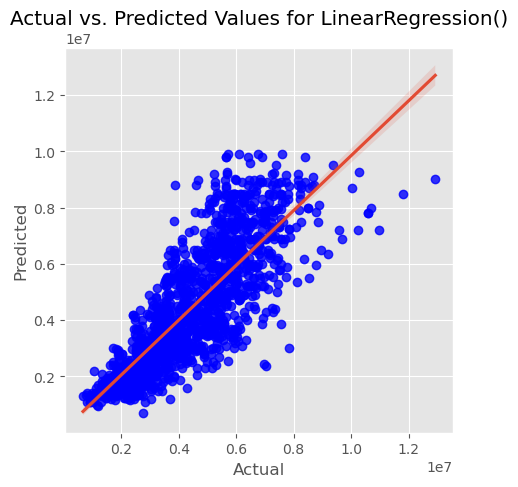

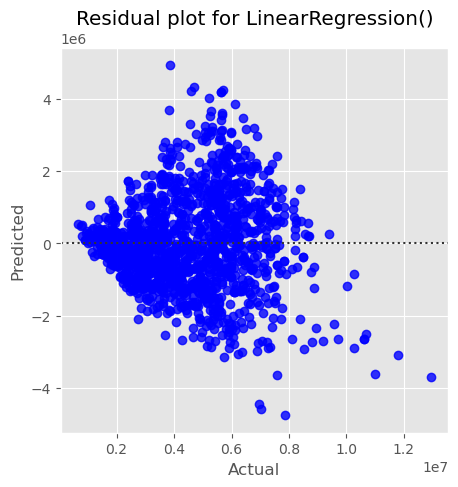

In [34]:
# use linear regression model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)

evaluate_model(lr, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Lasso(alpha=0.01, tol=0.1): 0.663609
R^2 of Lasso(alpha=0.01, tol=0.1): 0.653995
RMSE of Lasso(alpha=0.01, tol=0.1): 1303359.0592


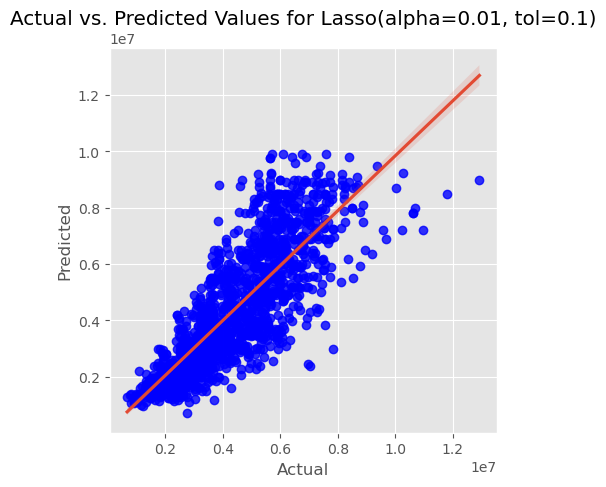

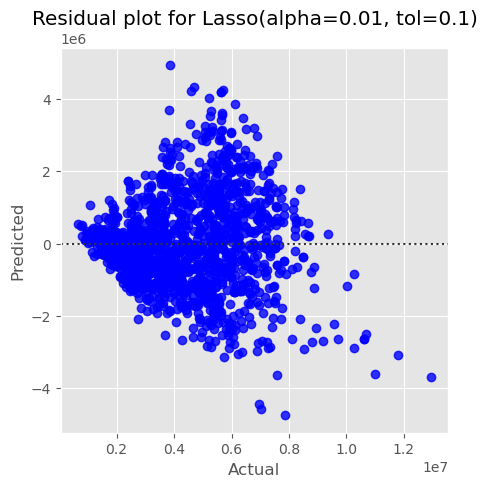

In [35]:
# use lasso model
lasso = Lasso(alpha=0.01, tol=0.1)
lasso.fit(X_train_sc, y_train)
y_pred = lasso.predict(X_test_sc)

evaluate_model(lasso, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Ridge(): 0.663806
R^2 of Ridge(): 0.653959
RMSE of Ridge(): 1303428.1954


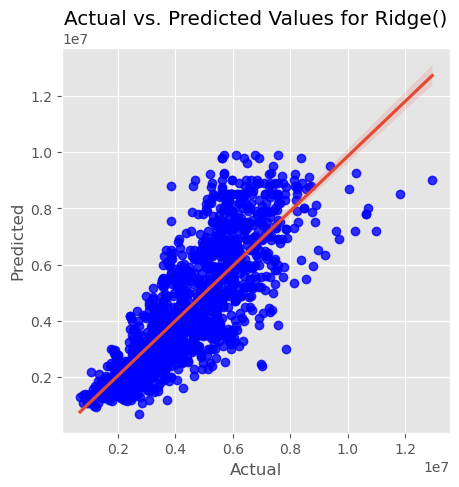

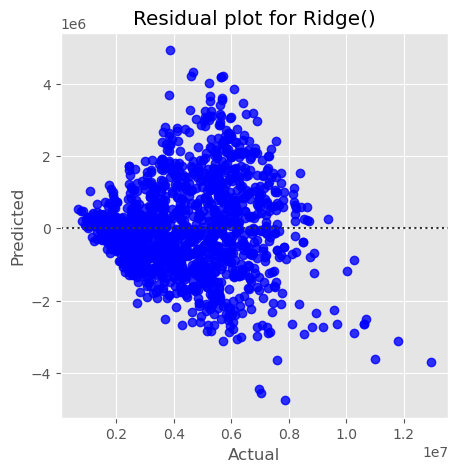

In [36]:
# use Ridge model
ridge = Ridge()
ridge.fit(X_train_sc, y_train)
y_pred = ridge.predict(X_test_sc)

evaluate_model(ridge, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

#### Conclusion

- Linear Regression also outperformed Lasso and Ridge in terms of cross-validation Rู^2 and RMSE.
- Linear Regression had the highest cross-validation R^2 and lowest RMSE compared to Lasso and Ridge.

### Model 3 [Presentation]. Predict condo with underserved 7-11 store

As a large corporation, 7-11 has strong control over revenue, profit, and loss, suggesting overall economic equilibrium. However, some locations may be underserved.

We're building a model to predict the relationship between condo units and 7-11 stores.

In [41]:
# Get dummy for district name
train_store_zone_df = pd.get_dummies(train_store_zone_df, columns=['district'])
# Back up the original data before creating dummy variables for later use
train_store_zone_df['zone_name_'] = train_store_zone_df['zone_name']
# Get dummy columns
train_store_zone_df = pd.get_dummies(train_store_zone_df, columns=['zone_name'])
# Restore zone_name from the backup
train_store_zone_df['zone_name'] = train_store_zone_df['zone_name_']
train_store_zone_df.drop('zone_name_', inplace=True, axis=1)

In [42]:
features = {c for c in train_store_zone_df.columns if re.search(r'total_units|zone_name_|district_', c)}
features = sorted(features)
X = train_store_zone_df[features]
y = train_store_zone_df['nearby_711_store_num'].fillna(0)
#train_store_zone_df.info()

#### Train-Test split data

In [44]:
# split data for training and test with ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### Training models & compare result

In [46]:
# scale X values
# Scale the training data
sc = RobustScaler()
X_train_sc = sc.fit_transform(X_train)
# Transform the predict data
X_test_sc = sc.transform(X_test)

Cross Validation Score of LinearRegression(): 0.439861
R^2 of LinearRegression(): 0.466403
RMSE of LinearRegression(): 4.3836


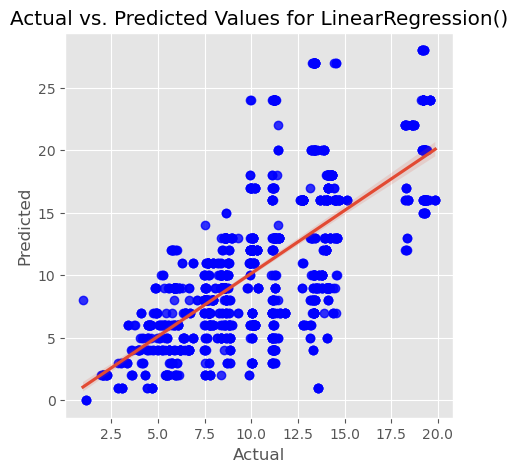

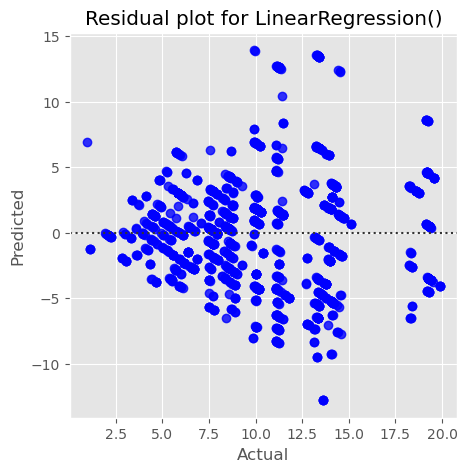

In [47]:
# use linear regression model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)

evaluate_model(lr, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Lasso(alpha=0.01, tol=0.1): 0.433686
R^2 of Lasso(alpha=0.01, tol=0.1): 0.459980
RMSE of Lasso(alpha=0.01, tol=0.1): 4.4099


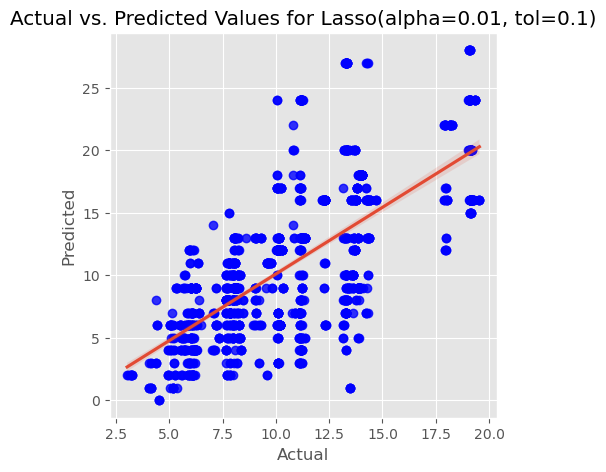

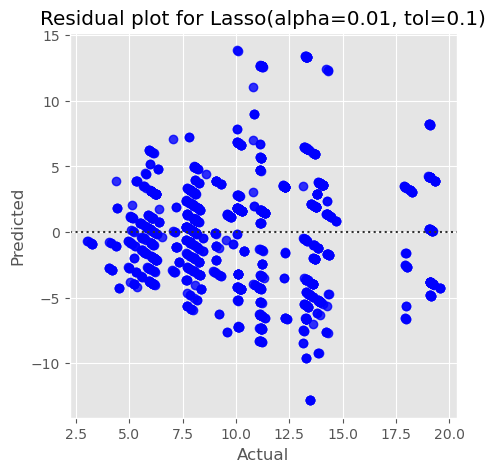

In [48]:
# use lasso model
lasso = Lasso(alpha=0.01, max_iter=1000, tol=0.1)
lasso.fit(X_train_sc, y_train)
y_pred = lasso.predict(X_test_sc)

evaluate_model(lasso, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

Cross Validation Score of Ridge(): 0.439877
R^2 of Ridge(): 0.467049
RMSE of Ridge(): 4.3810


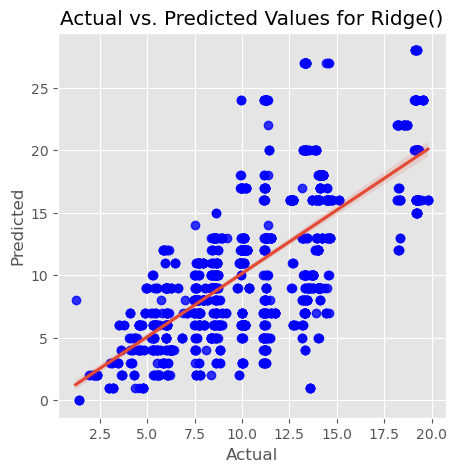

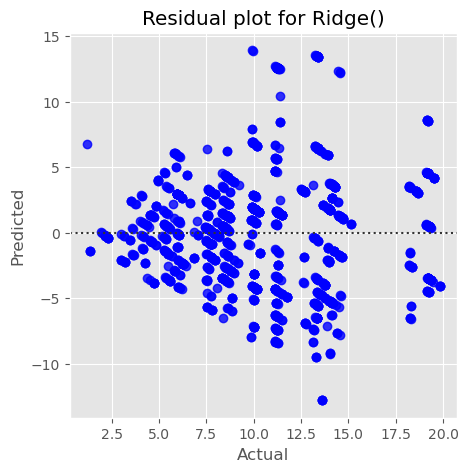

In [49]:
# use Ridge model
ridge = Ridge()
ridge.fit(X_train_sc, y_train)
y_pred = ridge.predict(X_test_sc)

evaluate_model(ridge, X, X_train_sc, X_test_sc, y, y_train, y_test, y_pred)

##### Train and predict underserved condo with linear regression model

In [51]:
sc = RobustScaler()
# Scale the training data
X_train_sc = sc.fit_transform(X_train)

# Transform the predict data
X_predict_sc = sc.transform(X)

# Training to predict underserve area, with condo project
lr.fit(X_train_sc, y_train)

LinearRegression()

In [52]:
# Forecasting 7-11 store nearby
train_store_zone_df['predict_nearby_711_store_num'] = lr.predict(X_predict_sc)

In [53]:
# Count only uniq condo project (by coordination)

# Filter result for uniq condo location
train_uniq_store_zone_df = train_store_zone_df.drop_duplicates(subset=['latitude', 'longitude'])

# Count number underserved 711
underserved_711 = train_uniq_store_zone_df[train_uniq_store_zone_df['nearby_711_store_num'] < train_uniq_store_zone_df['predict_nearby_711_store_num']] \
.groupby('zone_name')['id'].count().reset_index()

# Rename column for number of Condo
underserved_711.rename({'id': 'number'}, axis=1, inplace=True)

In [54]:
# Show number of the underserved
underserved_711

,zone_name,number
0,Zone 1,40
1,Zone 2,354
2,Zone 3,110
3,Zone 4,8
4,Zone 5,14
5,Zone 6,14


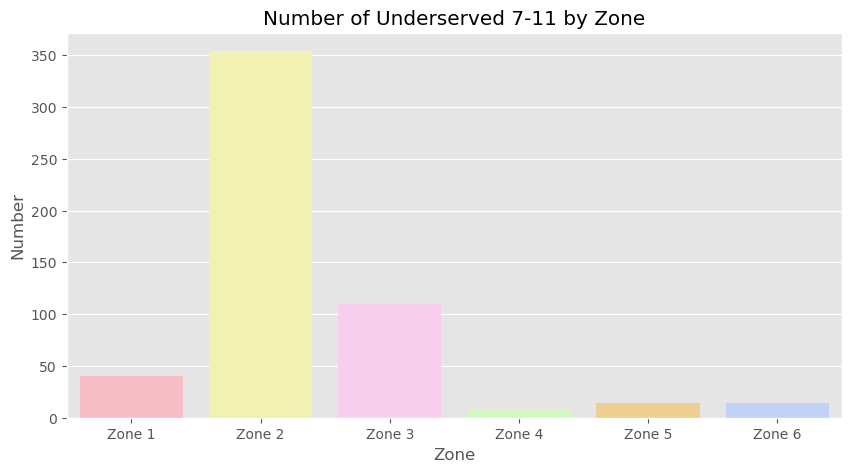

In [55]:
# Plot the number of underserved
plt.figure(figsize=(10,5))
sns.barplot(x='zone_name', y='number', data=underserved_711, palette=palette)
plt.xlabel('Zone')
plt.ylabel('Number')
plt.title('Number of Underserved 7-11 by Zone')
plt.savefig('../figures/underserved_store.png');